In [44]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Lesson2

In [45]:
from fastai import *
from fastai.vision import *

## 使用Google的图片搜索创建自己的数据集

[hardikvasa/google-images-download: Python Script to download hundreds of images from 'Google Images'. It is a ready-to-run code!](https://github.com/hardikvasa/google-images-download)

In [46]:
# 下载 南瓜，西瓜，冬瓜各100张创建数据集

In [47]:
# from google_images_download import google_images_download

In [48]:
# response = google_images_download.googleimagesdownload()
# # limit 最大只能为100
# arguments = {"keywords": "Watermelon, Pumpkin, Winter melon", "limit": 100, "print_urls": True}
# paths = response.download(arguments)
# paths  # 文件保存路径

[How to create a deep learning dataset using Google Images - PyImageSearch](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)

In [49]:
# folder = 'watermelon'
# file = 'urls_watermelon.txt'

# folder = 'pumpkin'
# file = 'urls_pumpkin.txt'

# folder = 'winter_melon'
# file = 'urls_winter_melon.txt'

In [50]:
# path = Path('datasets/images')
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [51]:
# path.ls()

In [52]:
# download_images(path/file, dest, max_pics=400)

In [53]:
classes = ['watermelon', 'pumpkin', 'winter_melon']

对下载的数据删除 .png 格式的图片，同时删掉质量差的图片，为了使类别均衡，我们使用相同数量的图片，每个类别大约 150 

In [54]:
path = Path('datasets/images')

In [55]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4, bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (360 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
watermelon,watermelon,watermelon,watermelon,watermelon
Path: datasets/images;

Valid: LabelList (90 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pumpkin,pumpkin,watermelon,watermelon,pumpkin
Path: datasets/images;

Test: None

In [56]:
data.classes

['pumpkin', 'watermelon', 'winter_melon']

In [57]:
data.c, len(data.train_ds), len(data.valid_ds)

(3, 360, 90)

看一下创建的数据

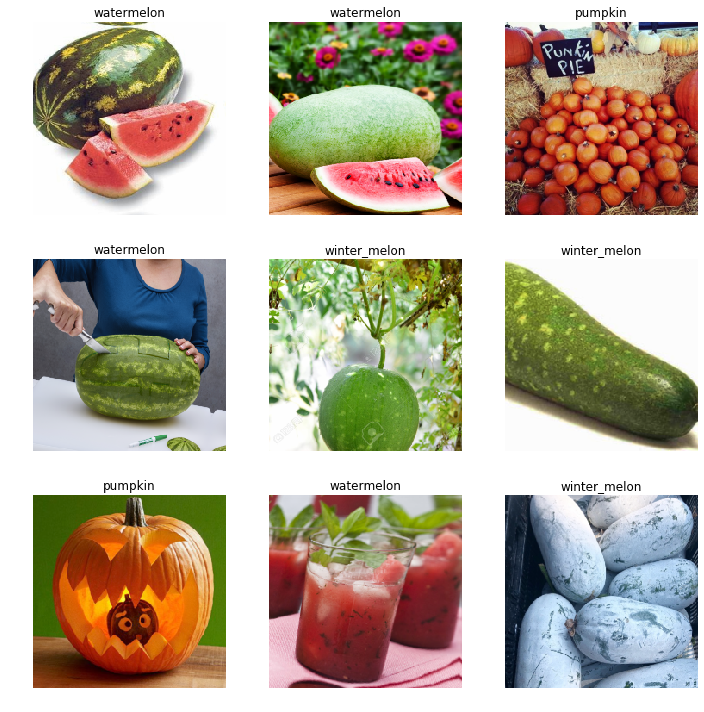

In [58]:
data.show_batch(rows=3, figsize=(10, 10))

## 创建学习器

In [73]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [74]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (360 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
watermelon,watermelon,watermelon,watermelon,watermelon
Path: datasets/images;

Valid: LabelList (90 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pumpkin,pumpkin,watermelon,watermelon,pumpkin
Path: datasets/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

### stage1

In [77]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,0.204981,0.106310,0.966667,00:14
1,0.172727,0.129524,0.955556,00:15
2,0.160953,0.123730,0.955556,00:15
3,0.134284,0.099898,0.966667,00:15
4,0.105127,0.094057,0.955556,00:15
5,0.126335,0.092937,0.955556,00:14


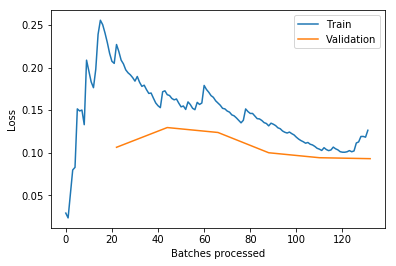

In [78]:
learn.recorder.plot_losses()

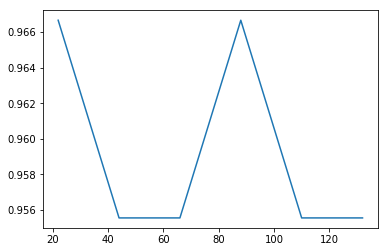

In [79]:
learn.recorder.plot_metrics()

In [65]:
# save
learn.save('stage-1')

### stage 2

1. learn.unfreeze
2. 找学习率
3. 再次训练

In [85]:
learn.unfreeze()

In [88]:
learn.lr_find(start_lr=1e-8, end_lr=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


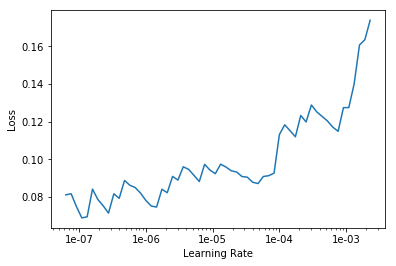

In [89]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(6, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.039405,0.075021,0.955556,00:20
1,0.035316,0.073315,0.966667,00:20
2,0.032984,0.097482,0.955556,00:20
3,0.029166,0.076976,0.966667,00:20
4,0.038434,0.080663,0.977778,00:20
5,0.034193,0.085327,0.966667,00:20


In [24]:
learn.save('stage-2')

现在达到了 97% 的准确率

## stage3 模型解释

In [25]:
learn.load('stage-2');
inter = ClassificationInterpretation.from_learner(learn)

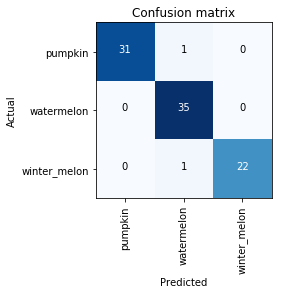

In [26]:
inter.plot_confusion_matrix()

In [27]:
inter.most_confused(min_val=1)

[('pumpkin', 'watermelon', 1), ('winter_melon', 'watermelon', 1)]

一些数据质量差会导致，我们的预测也变差，我们尝试删除它们

In [28]:
from fastai.widgets import *

不直接删除文件本身，而是创建一个 csv 文件来保存正确的图片信息

In [29]:
losses,idxs = inter.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [30]:
losses
idxs
top_loss_paths

tensor([4.3220e+00, 7.4722e-01, 5.8403e-01, 5.1694e-01, 5.1431e-01, 2.6240e-01,
        1.5444e-01, 1.4843e-01, 1.0271e-01, 9.3997e-02, 9.3997e-02, 8.6681e-02,
        6.9532e-02, 4.6092e-02, 4.5628e-02, 3.0114e-02, 2.8111e-02, 1.9760e-02,
        1.8813e-02, 1.6084e-02, 1.5474e-02, 1.4099e-02, 1.2501e-02, 9.0442e-03,
        8.8148e-03, 7.8230e-03, 7.3333e-03, 5.9299e-03, 5.8532e-03, 5.5747e-03,
        5.5270e-03, 5.1718e-03, 5.1386e-03, 4.9968e-03, 4.2694e-03, 4.2443e-03,
        3.5882e-03, 3.3174e-03, 3.1309e-03, 2.9759e-03, 2.2392e-03, 2.1572e-03,
        2.1415e-03, 1.7490e-03, 1.6766e-03, 1.5001e-03, 1.3909e-03, 1.2965e-03,
        1.2660e-03, 1.0095e-03, 9.1124e-04, 8.2493e-04, 6.8760e-04, 6.6042e-04,
        6.5708e-04, 5.8460e-04, 5.0831e-04, 4.8876e-04, 4.8256e-04, 4.6444e-04,
        4.4584e-04, 4.1914e-04, 3.8290e-04, 3.7813e-04, 3.6812e-04, 2.9802e-04,
        2.4414e-04, 1.8406e-04, 1.3065e-04, 1.1587e-04, 9.4414e-05, 9.1553e-05,
        8.9645e-05, 8.3923e-05, 7.5817e-

tensor([44, 68, 32, 83, 18, 63, 42, 69, 67, 65, 11, 64, 46, 31, 19, 38, 35, 53,
        70, 55, 60, 81, 80, 84, 49, 71, 28, 17, 36, 85, 43, 12, 57, 22, 88, 26,
        21, 14, 76, 50, 41,  4, 54, 74,  6, 77,  1, 39, 16, 15, 62,  5, 79, 52,
        82, 25, 87, 56, 73, 78, 51, 37, 72, 40, 33, 13, 29, 30, 20,  8, 10,  9,
        75, 48, 34, 89, 24, 59, 58, 45, 61,  7, 47, 86,  3, 27,  0,  2, 23, 66])

ImageList (90 items)
Image (3, 853, 1280),Image (3, 480, 480),Image (3, 720, 720),Image (3, 355, 355),Image (3, 500, 500)
Path: datasets/images

In [31]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [32]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## 预测

In [33]:
learn.export()

In [34]:
defaults.device = torch.device('cpu')

In [35]:
path

PosixPath('datasets/images')

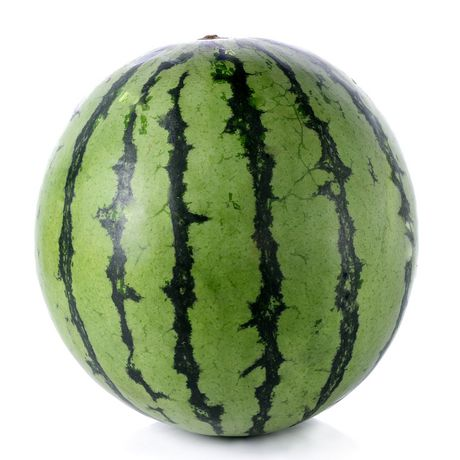

In [36]:
img = open_image(path/'watermelon'/'00000025.jpg')
img

In [37]:
learn = load_learner(path)

In [38]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category watermelon

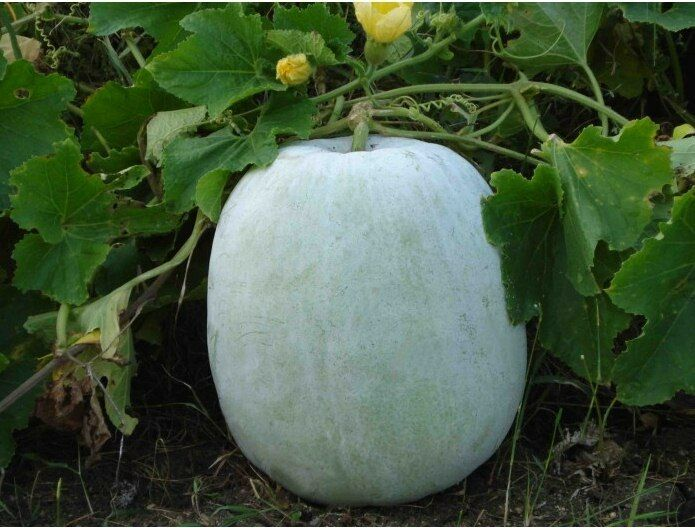

In [39]:
img = open_image(path/'winter_melon'/'00000015.jpg')
img

In [40]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category winter_melon

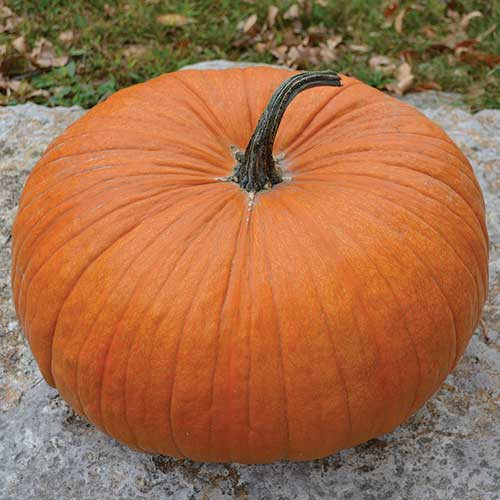

In [41]:
img = open_image(path/'pumpkin'/'00000025.jpg')
img

In [42]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category pumpkin

* 太高的学习率会导致验证损失非常大（通常其应该小于1）
* 太低的学习率会导致训练速度太慢，其特征是训练损失大于验证损失，这个时候可以多训练几次也可以增大学习率
* 我们可以通过画出损失的图像来判断我们是否设置了合理的学习率
* 所有正确训练的模型都是训练损失小于验证损失，当训练损失小于验证损失就是过拟合这一理解不是绝对正确的
* 对所有layer进行训练的时候，最大的lr通常为只对最后layer训练的lr的1/10